# Transfer Learning, GPUs e TPUs
Esse notebook foi criado com base no tutorial de Ryan Holbrook, disponível no próprio Kaggle: https://www.kaggle.com/ryanholbrook/create-your-first-submission

A competição de Flower Classification on TPU foi criada para ensinar os usuários a utilizarem os recursos de aceleradores do Kaggle, pois treinar uma rede neural no dataset dessa competição usando só a CPU seria extremamente demorado.

## 0 - Importações

In [ ]:
# Usados na importação e tratamento dos dados
import math, re, os
import numpy as np

# Biblioteca de redes neurais
import tensorflow as tf

# Necessário para rodar em TPU
from kaggle_datasets import KaggleDatasets

Existem 3 modos de executar seus códigos no Kaggle:
* **CPU** (sem acelerador): Processador comum, é suficiente para algumas aplicações, mas quase nunca dá conta para redes neurais grandes, que usam muitos dados no treinamento.
* **GPU**: Unidade de processamento especializada em processar blocos de dados em paralelo. Torna o treinamento das redes muito mais rápido, pois as bibliotecas tomam proveito dessa propriedade para executar multiplas operações simultâneamente (Vectorization).
* **TPU**: Hardware especializado (ASIC) para executar código do TensorFlow. Por ser especializado tende a ter a melhor performance, mas também tem várias particularidades.

Então, **como eu uso esses aceleradores?**

No caso do seu próprio PC o tensorflow a CPU já funciona sem mudar nada, mas se você quiser usar uma GPU você deve seguir a documentação para garantir que a biblioteca consiga utilizar esse recurso:
https://www.tensorflow.org/install/gpu

Obs: Por padrão o tensorflow só funciona com placas de vídeo da Nvidia (inclusive pode funcionar só de ter os drivers instalados). Para placas da AMD existem meios alternativos, mas nenhum oficial do TensorFlow.

No Kaggle o procedimento é mais simples: é só clicar nos três pontos do canto superior direto, depois em "Accelerator" e escolher um acelerador. 

**Mas por quê esses recursos aceleram o treinamento?**

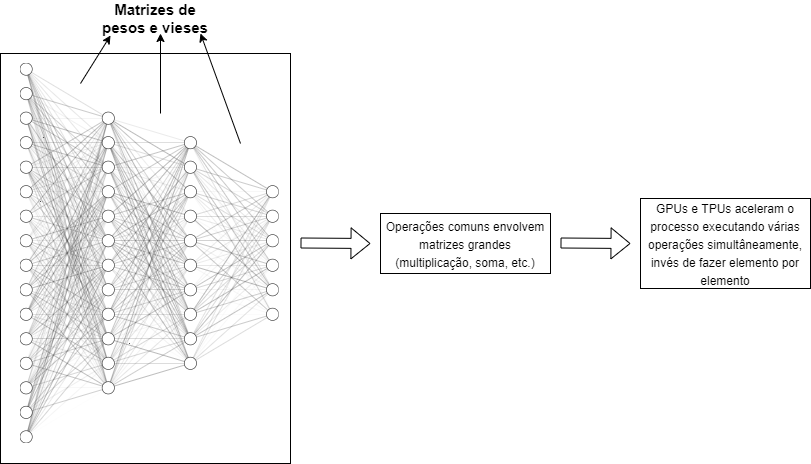

## 1 - Configurações iniciais e importação dos dados
Primeiramente, como queremos ter a possibilidade de rodar o código em uma TPU, precisamos definir uma estratégia de distribuição. Isso é necessário, pois rodar algo em TPU é como rodar em várias GPUs ou CPUs, e essa definição distribui o treinamento nos vários núcleos da TPU.

In [ ]:
# Tenta se conectar em uma TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

# Se consegui configura para rodar na TPU
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
# Senão define uma estratégia que funciona para CPU ou GPU
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Para executar o código em uma TPU também é necessário usar um dataset armazenado em um Google Cloud Storage Bucket. No caso de dados disponíveis no Kaggle, é possível conseguir o path adequado usando a biblioteca kaggle_datasets.

In [ ]:
# Adquire o path do Google Cloud Storage para o dataset dessa competição 
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH)

Em seguida, é preciso importar os dados e transformar as imagens para elas ficarem em um formato adequado para serem utilizadas pela rede neural. Nesse notebook o código para isso é o mesmo apresentado por Ryan Holbrook em: https://www.kaggle.com/ryanholbrook/create-your-first-submission.

Recomendo muito ler esse tutorial para ter mais detalhes essa etapa.

In [ ]:
IMAGE_SIZE = [192, 192]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-192x192'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [ ]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

In [ ]:
# Define o tamanho do batch, baseando no número de núcleos de TPU disponíveis
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Gera os datasets separados em treino, validação e teste
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

## 2 - Definindo e treinando o modelo
Em geral é difícil decidir uma arquitetura de rede neural do zero, por isso, em muitos casos compensa adotar uma arquitetura já existente para o problema que queremos resolver. Essas redes podem ser encontradas pesquisando artigos recentes sobre alguma área específica, por exemplo, classificação de imagens que é o caso desse dataset.

#### Transfer Learning
Podemos usar pedaço de um modelo já treinado em algum dataset para começar na frente em algum dataset novo.
Isso é feito reutilizando os parâmetros treinados como inicialização para a rede invés de iniciar os pesos e viéses do zero. Também é comum "congelar" camadas para que não sejam treinadas. Isso também ajuda a acelerar o treinamento.

Esse procedimento funciona pois as features aprendidas pela rede são reutilizadas ao usar os pesos de uma rede já treinada em um problema parecido. É comum achar redes de artigos já treinadas em datasets como o ImageNet para o problema de classificação de imagens, inclusive várias estão implementadas no próprio TensorFlow.

Algumas redes implementadas no Keras podem ser encontradas em tf.keras.applications: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
with strategy.scope():
    # Importando o modelo já treinado
    model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        # Exclui a última camada, vai ser trocada para ser específica para o problema 
        include_top=False ,
        # Define o tamanho do dado de entrada
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    # "Congela" os pesos da rede, assim só a última camada nova vai ser treinada
    model.trainable = False
    
    model = tf.keras.Sequential([
        # O modelo base está treinado com ImageNet
        model,
        # O final da rede é alterado para se adequar ao problema
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
# Definindo o otimizador, função perda e métricas
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

In [ ]:
EPOCHS = 10
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)

#### Comparação de tempo para cada acelerador:
* **CPU**: Aproximadamente 13 minutos por época
* **GPU**: 33-34 segundos por época.
* **TPU**: 5-6 segundos por época.

Sugiro rodar esse notebook mudando o acelerador do Kaggle para observar a diferença no tempo de treinamento. 

#### Sem transfer Learning:

In [ ]:
with strategy.scope():
    model = tf.keras.applications.xception.Xception(
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    
    model = tf.keras.Sequential([
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)

É possível ver que o modelo teve uma acurácia maior sem aplicar transfer learning, isso provavelmente é uma consequência de todos os pesos serem treinados para esse problema específico. Apesar disso, usar transfer learning fez com que o modelo tivesse uma acurácia melhor nas primeiras épocas. Tendo isso em vista, pode ser interessante treinar o modelo com pesos iniciais da ImageNet, mas todas as camadas treináveis.

#### Transfer learning sem congelar as camadas iniciais:

In [ ]:
with strategy.scope():
    model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    
    model = tf.keras.Sequential([
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)